### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

print("Libraries imported successfully!")

Libraries imported successfully!


### Set plotting style

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Ready to build water quality forecasting model")


Ready to build water quality forecasting model


### ===== DATA LOADING AND INITIAL EXPLORATION =====

In [3]:
def load_and_explore_data(file_path):
    """Load dataset and perform initial exploration"""
    try:
        df = pd.read_csv(file_path) 
        
        print(f"Dataset shape: {df.shape}")
        print("\nFirst few rows:")
        print(df.head())
        
        print("\nDataset info:")
        print(df.info())
        
        print("\nBasic statistics:")
        print(df.describe())
        
        print("\nRain distribution:")
        rain_labels = {0: 'No Rain', 1: 'Light Rain', 2: 'Moderate Rain', 3: 'Heavy Rain'}
        print(df['isRaining'].map(rain_labels).value_counts())
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_and_explore_data('C:\Projects\Pureflow-AI\water_quality_dataset.csv')

Dataset shape: (26281, 6)

First few rows:
              datetime    pH  temperature  salinity  turbidity  isRaining
0  2022-01-01 00:00:00  7.35          3.2      36.5        3.1          0
1  2022-01-01 01:00:00  7.33          2.1      35.6        3.2          0
2  2022-01-01 02:00:00  6.92          3.9      34.6        3.0          0
3  2022-01-01 03:00:00  7.17          6.1      33.5        2.6          0
4  2022-01-01 04:00:00  7.57          3.4      33.7        4.3          0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26281 entries, 0 to 26280
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     26281 non-null  object 
 1   pH           26281 non-null  float64
 2   temperature  26281 non-null  float64
 3   salinity     26281 non-null  float64
 4   turbidity    26281 non-null  float64
 5   isRaining    26281 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 

### ===== DATA PREPROCESSING =====

In [4]:
def preprocess_data(df):
    """Clean and preprocess the dataset, optimized for Philippine seasons (summer/rainy)"""
    df_processed = df.copy()
    
    # Convert datetime to proper format
    df_processed['datetime'] = pd.to_datetime(df_processed['datetime'])
    
    # Map isRaining string values to integer codes
    rain_map = {
        'Not Raining': 0,
        'Shower': 1,
        'Light': 1,
        'Light Rain': 1,
        'Moderate': 2,
        'Moderate Rain': 2,
        'Heavy': 3,
        'Heavy Rain': 3
    }
    df_processed['isRaining'] = df_processed['isRaining'].map(rain_map).fillna(0).astype(int)
    
    # Extract time-based features
    df_processed['year'] = df_processed['datetime'].dt.year
    df_processed['month'] = df_processed['datetime'].dt.month
    df_processed['day'] = df_processed['datetime'].dt.day
    df_processed['hour'] = df_processed['datetime'].dt.hour
    df_processed['day_of_year'] = df_processed['datetime'].dt.dayofyear
    
    # Philippine season: 0 = Dry/Summer (Dec-May), 1 = Rainy (Jun-Nov)
    df_processed['season'] = df_processed['month'].apply(lambda m: 0 if 12 <= m or m <= 5 else 1)
    
    # Create cyclical features for time
    df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12)
    df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12)
    df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24)
    df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24)
    
    # Create lag features (previous values)
    water_params = ['pH', 'temperature', 'salinity', 'turbidity']
    for param in water_params:
        df_processed[f'{param}_lag1'] = df_processed[param].shift(1)
        df_processed[f'{param}_lag24'] = df_processed[param].shift(24)
    
    # Rain intensity features
    df_processed['rain_binary'] = (df_processed['isRaining'] > 0).astype(int)
    df_processed['rain_intensity'] = df_processed['isRaining']
    
    # Rolling statistics for rain
    df_processed['rain_last_6h'] = df_processed['rain_binary'].rolling(window=6).sum()
    df_processed['rain_last_24h'] = df_processed['rain_binary'].rolling(window=24).sum()
    
    # Remove rows with NaN values created by lag features
    df_processed = df_processed.dropna()
    
    print(f"Processed dataset shape: {df_processed.shape}")
    print("Feature engineering completed! (0=Summer, 1=Rainy)")
    
    return df_processed

df_processed = preprocess_data(df)

Processed dataset shape: (26257, 28)
Feature engineering completed! (0=Summer, 1=Rainy)


### ===== EXPLORATORY DATA ANALYSIS =====

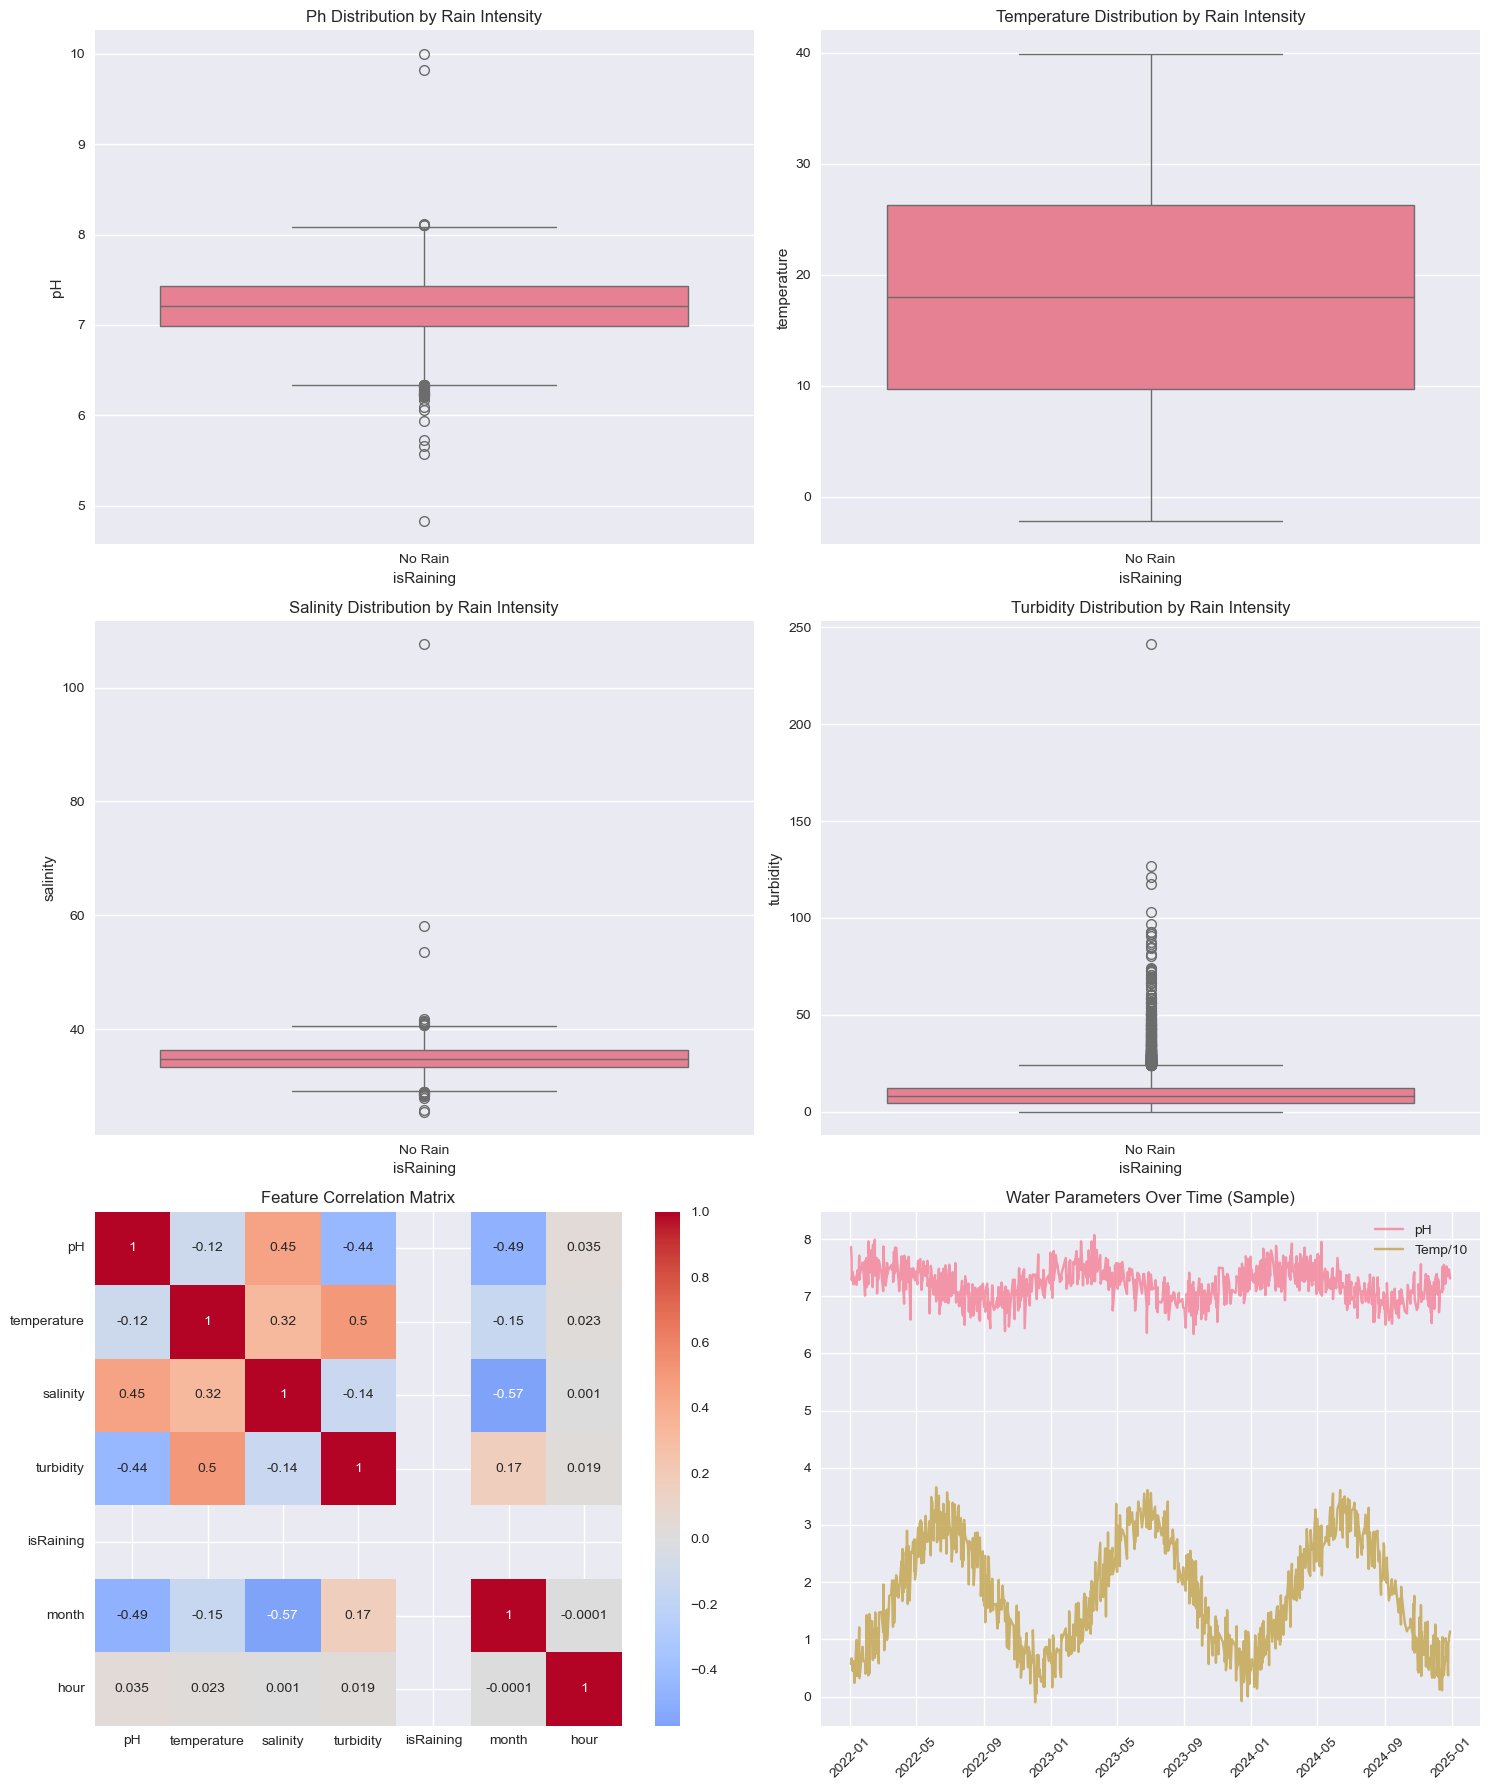


=== RAIN IMPACT ANALYSIS ===

PH:
  No Rain: μ=7.20, σ=0.30, n=26257.0

TEMPERATURE:
  No Rain: μ=18.01, σ=9.29, n=26257.0

SALINITY:
  No Rain: μ=34.84, σ=2.03, n=26257.0

TURBIDITY:
  No Rain: μ=9.45, σ=6.99, n=26257.0


In [5]:
def perform_eda(df):
    """Perform exploratory data analysis"""
    
    # Set up the plotting area
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # 1. Water parameters distribution by rain condition
    water_params = ['pH', 'temperature', 'salinity', 'turbidity']
    rain_labels = {0: 'No Rain', 1: 'Light', 2: 'Moderate', 3: 'Heavy'}
    
    for i, param in enumerate(water_params):
        row = i // 2
        col = i % 2
        
        sns.boxplot(data=df, x='isRaining', y=param, ax=axes[row, col])
        axes[row, col].set_title(f'{param.title()} Distribution by Rain Intensity')
        axes[row, col].set_xticklabels([rain_labels[x] for x in sorted(df['isRaining'].unique())])
    
    # 5. Correlation heatmap
    correlation_features = ['pH', 'temperature', 'salinity', 'turbidity', 'isRaining', 
                           'month', 'hour']
    corr_matrix = df[correlation_features].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 0])
    axes[2, 0].set_title('Feature Correlation Matrix')
    
    # 6. Time series of water parameters
    sample_data = df.sample(n=min(1000, len(df))).sort_values('datetime')
    axes[2, 1].plot(sample_data['datetime'], sample_data['pH'], alpha=0.7, label='pH')
    axes[2, 1].plot(sample_data['datetime'], sample_data['temperature']/10, alpha=0.7, label='Temp/10')
    axes[2, 1].set_title('Water Parameters Over Time (Sample)')
    axes[2, 1].legend()
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print("\n=== RAIN IMPACT ANALYSIS ===")
    for param in water_params:
        print(f"\n{param.upper()}:")
        rain_stats = df.groupby('isRaining')[param].agg(['mean', 'std', 'count'])
        for rain_level in sorted(df['isRaining'].unique()):
            stats = rain_stats.loc[rain_level]
            print(f"  {rain_labels[rain_level]}: μ={stats['mean']:.2f}, σ={stats['std']:.2f}, n={stats['count']}")

perform_eda(df_processed)

### ===== MODEL BUILDING =====

In [6]:
def prepare_model_data(df):
    """Prepare features and targets for modeling"""
    
    # Define features and targets
    feature_cols = [
        'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'season',
        'rain_binary', 'rain_intensity', 'rain_last_6h', 'rain_last_24h',
        'pH_lag1', 'temperature_lag1', 'salinity_lag1', 'turbidity_lag1',
        'pH_lag24', 'temperature_lag24', 'salinity_lag24', 'turbidity_lag24'
    ]
    
    target_cols = ['pH', 'temperature', 'salinity', 'turbidity']
    
    # Prepare data
    X = df[feature_cols].copy()
    y = df[target_cols].copy()
    
    print(f"Features shape: {X.shape}")
    print(f"Targets shape: {y.shape}")
    print(f"Feature columns: {list(X.columns)}")
    
    return X, y, feature_cols, target_cols


### Trains Multiple Models and Perform Performance Comparison

In [7]:
def train_models(X, y):

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Training multiple models...")
    
    models = {
        'Random Forest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
        'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
        'Linear Regression': MultiOutputRegressor(LinearRegression())
    }
    
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use scaled data for Linear Regression, original for tree-based models
        if 'Linear' in name:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics for each target
        model_results = {}
        for i, target in enumerate(y.columns):
            r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
            rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
            mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
            
            model_results[target] = {
                'R2': r2,
                'RMSE': rmse,
                'MAE': mae
            }
        
        results[name] = model_results
        trained_models[name] = model
        
        print(f"{name} training completed!")
    
    return results, trained_models, scaler, (X_train, X_test, y_train, y_test)


### Prepare data and train models

In [8]:
X, y, feature_cols, target_cols = prepare_model_data(df_processed)
results, trained_models, scaler, (X_train, X_test, y_train, y_test) = train_models(X, y)

Features shape: (26257, 17)
Targets shape: (26257, 4)
Feature columns: ['month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'season', 'rain_binary', 'rain_intensity', 'rain_last_6h', 'rain_last_24h', 'pH_lag1', 'temperature_lag1', 'salinity_lag1', 'turbidity_lag1', 'pH_lag24', 'temperature_lag24', 'salinity_lag24', 'turbidity_lag24']
Training multiple models...

Training Random Forest...
Random Forest training completed!

Training Gradient Boosting...
Gradient Boosting training completed!

Training Linear Regression...
Linear Regression training completed!


### ===== MODEL BUILDING =====

In [9]:
def evaluate_models(results, target_cols):
    """Display model performance results"""
    
    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*60)
    
    # Create results DataFrame for better visualization
    results_df = []
    for model_name, model_results in results.items():
        for target, metrics in model_results.items():
            results_df.append({
                'Model': model_name,
                'Target': target,
                'R²': f"{metrics['R2']:.4f}",
                'RMSE': f"{metrics['RMSE']:.4f}",
                'MAE': f"{metrics['MAE']:.4f}"
            })
    
    results_df = pd.DataFrame(results_df)
    
    # Display results by target parameter
    for target in target_cols:
        print(f"\n{target.upper()} PREDICTION RESULTS:")
        target_results = results_df[results_df['Target'] == target]
        print(target_results[['Model', 'R²', 'RMSE', 'MAE']].to_string(index=False))
    
    # Find best model for each target
    print(f"\n{'BEST MODELS BY TARGET:'}")
    for target in target_cols:
        best_model = max(results.keys(), 
                        key=lambda x: results[x][target]['R2'])
        best_r2 = results[best_model][target]['R2']
        print(f"{target}: {best_model} (R² = {best_r2:.4f})")


### Actual Values Vs. Predicted Values


MODEL PERFORMANCE COMPARISON

PH PREDICTION RESULTS:
            Model     R²   RMSE    MAE
    Random Forest 0.4950 0.1776 0.1387
Gradient Boosting 0.5249 0.1723 0.1354
Linear Regression 0.5201 0.1732 0.1361

TEMPERATURE PREDICTION RESULTS:
            Model     R²   RMSE    MAE
    Random Forest 0.9471 2.2687 1.8118
Gradient Boosting 0.9507 2.1904 1.7505
Linear Regression 0.9503 2.1995 1.7564

SALINITY PREDICTION RESULTS:
            Model     R²   RMSE    MAE
    Random Forest 0.4190 1.3022 1.0151
Gradient Boosting 0.4415 1.2767 0.9938
Linear Regression 0.4430 1.2750 0.9922

TURBIDITY PREDICTION RESULTS:
            Model     R²   RMSE    MAE
    Random Forest 0.3988 5.0367 3.2229
Gradient Boosting 0.4118 4.9819 3.1135
Linear Regression 0.4135 4.9748 3.1806

BEST MODELS BY TARGET:
pH: Gradient Boosting (R² = 0.5249)
temperature: Gradient Boosting (R² = 0.9507)
salinity: Linear Regression (R² = 0.4430)
turbidity: Linear Regression (R² = 0.4135)


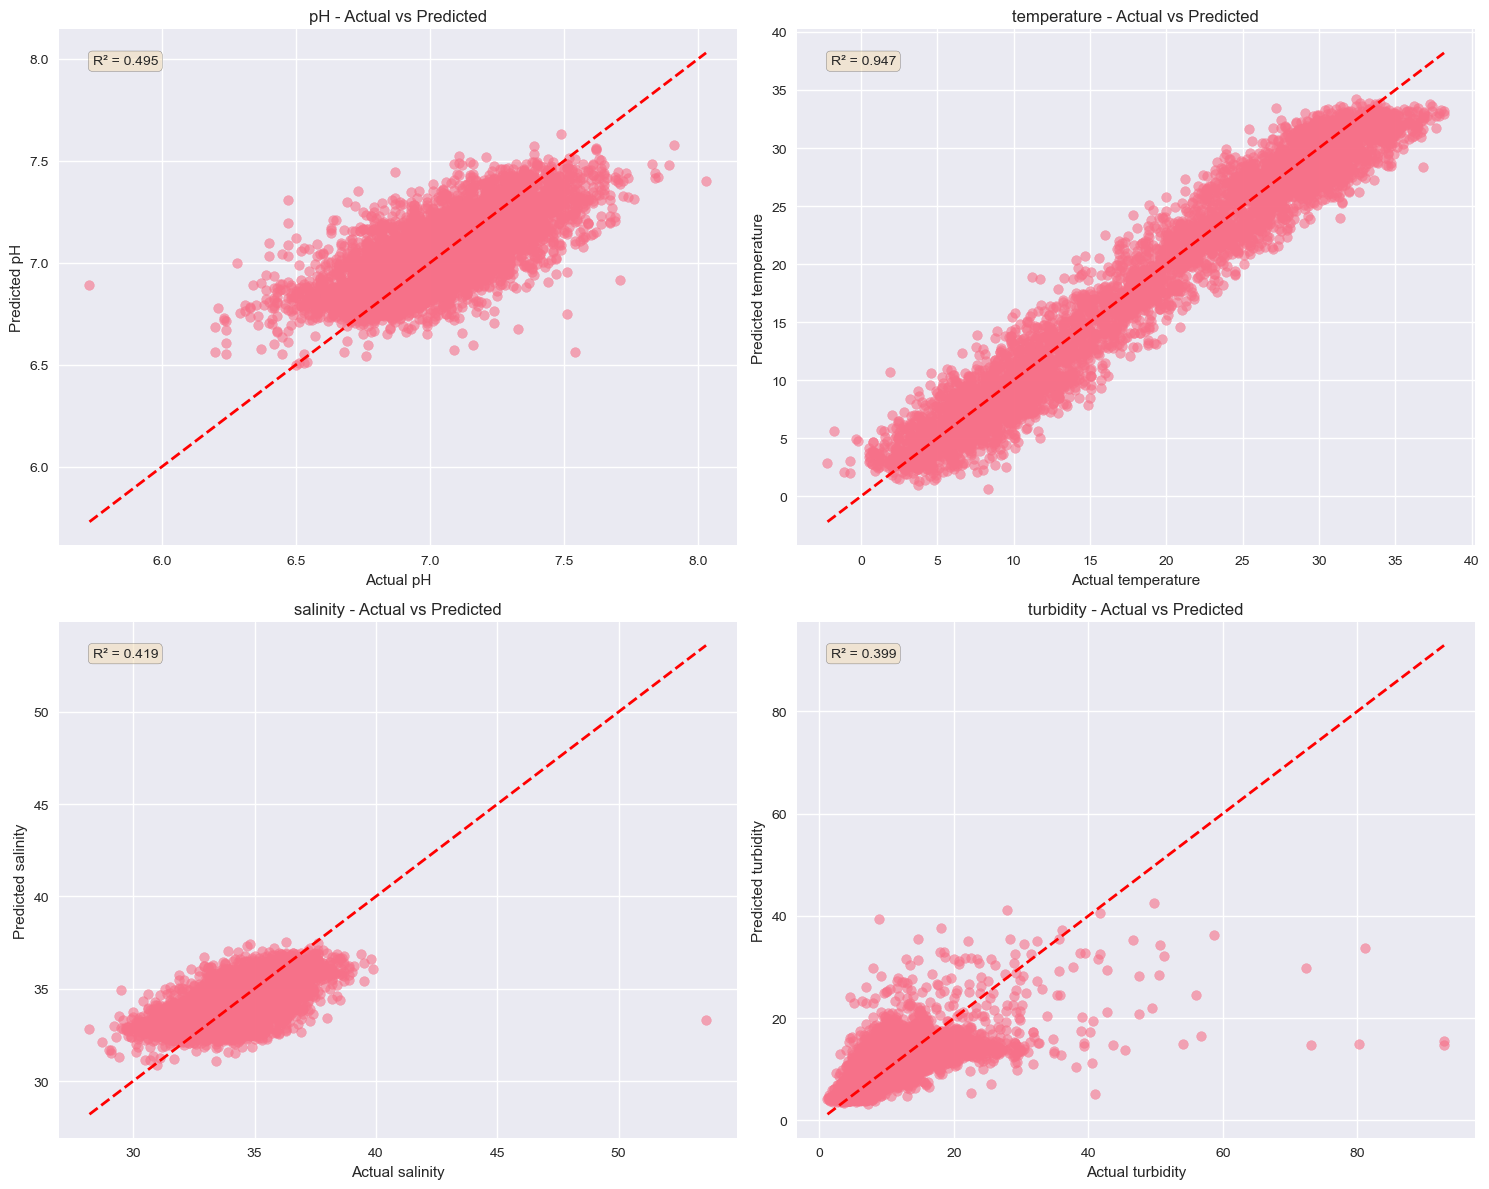

In [10]:

def plot_predictions(trained_models, X_test, y_test, scaler, target_cols):
    """Plot actual vs predicted values"""
    
    # Use the best performing model (Random Forest typically works well)
    best_model = trained_models['Random Forest']
    y_pred = best_model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    for i, target in enumerate(target_cols):
        row = i // 2
        col = i % 2
        
        axes[row, col].scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6)
        axes[row, col].plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
                           [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--', lw=2)
        axes[row, col].set_xlabel(f'Actual {target}')
        axes[row, col].set_ylabel(f'Predicted {target}')
        axes[row, col].set_title(f'{target} - Actual vs Predicted')
        
        # Add R² score to plot
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        axes[row, col].text(0.05, 0.95, f'R² = {r2:.3f}', 
                           transform=axes[row, col].transAxes, 
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Evaluate models
evaluate_models(results, target_cols)
plot_predictions(trained_models, X_test, y_test, scaler, target_cols)


### ===== FEATURE IMPORTANCE ANALYSIS =====

#### Analyze and visualize feature importance


Top 5 features for pH:
  month_sin: 0.0528
  pH_lag1: 0.0556
  turbidity_lag1: 0.0732
  hour_cos: 0.1530
  season: 0.4045

Top 5 features for temperature:
  turbidity_lag24: 0.0071
  hour_cos: 0.0109
  month_cos: 0.0114
  temperature_lag1: 0.2378
  temperature_lag24: 0.6951

Top 5 features for salinity:
  pH_lag1: 0.0535
  temperature_lag24: 0.0570
  turbidity_lag1: 0.0692
  month_cos: 0.1033
  month_sin: 0.4278

Top 5 features for turbidity:
  pH_lag1: 0.0553
  temperature_lag1: 0.0582
  temperature_lag24: 0.0594
  turbidity_lag24: 0.0707
  turbidity_lag1: 0.4326


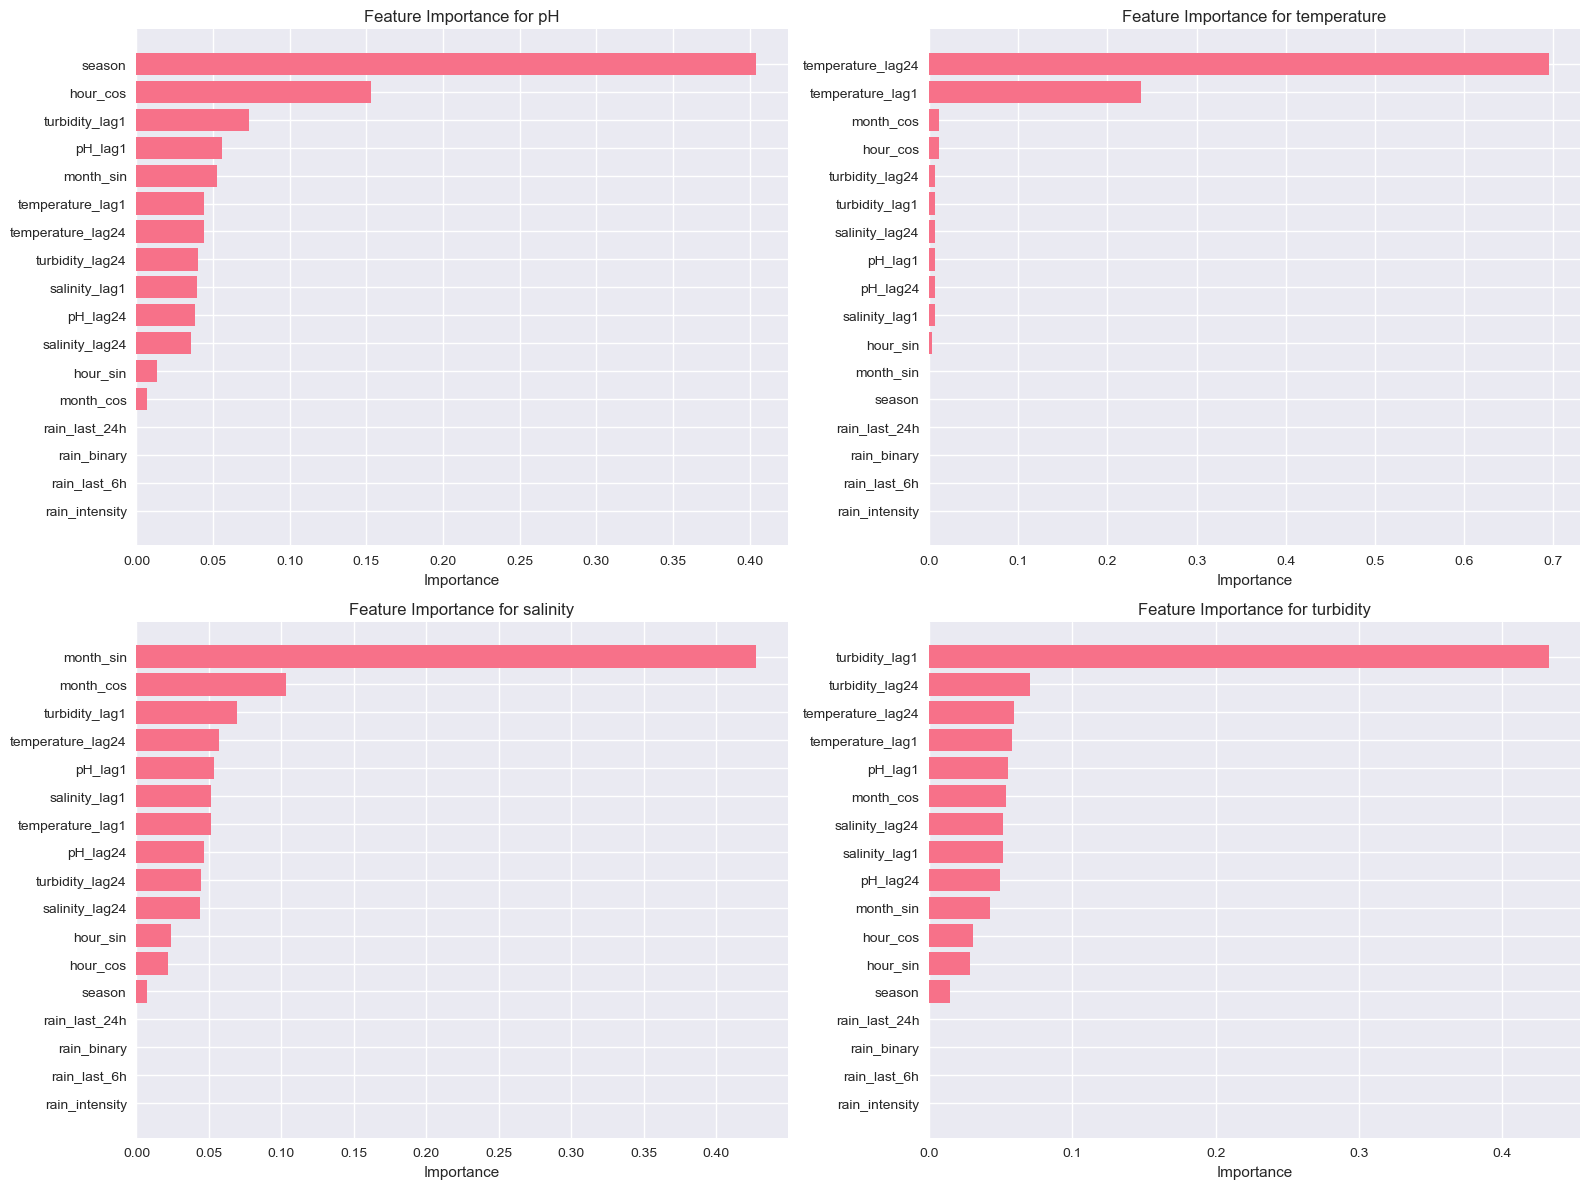

In [11]:
def analyze_feature_importance(trained_models, feature_cols, target_cols):
    # Get feature importance from Random Forest
    rf_model = trained_models['Random Forest']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, target in enumerate(target_cols):
        row = i // 2
        col = i % 2
        
        # Get feature importance for this target
        importance = rf_model.estimators_[i].feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importance
        }).sort_values('Importance', ascending=True)
        
        # Plot horizontal bar chart
        axes[row, col].barh(range(len(feature_importance_df)), 
                           feature_importance_df['Importance'])
        axes[row, col].set_yticks(range(len(feature_importance_df)))
        axes[row, col].set_yticklabels(feature_importance_df['Feature'])
        axes[row, col].set_xlabel('Importance')
        axes[row, col].set_title(f'Feature Importance for {target}')
        
        # Print top 5 features
        print(f"\nTop 5 features for {target}:")
        top_features = feature_importance_df.tail(5)
        for _, row_data in top_features.iterrows():
            print(f"  {row_data['Feature']}: {row_data['Importance']:.4f}")
    
    plt.tight_layout()
    plt.show()

analyze_feature_importance(trained_models, feature_cols, target_cols)


### ===== FORECASTING FUNCTION =====

##### Forecast water quality parameters based on rain forecast
    
#####    Parameters:
#####    - model: trained ML model
#####    - scaler: fitted StandardScaler
#####    - features: current feature values
#####    - rain_forecast: list of rain intensities for next hours
#####   - hours_ahead: number of hours to forecast

In [12]:
def forecast_water_quality(model, scaler, features, rain_forecast, hours_ahead=24):
    
    print(f"\nForecasting water quality for next {hours_ahead} hours...")
    print("Rain forecast:", [['No', 'Light', 'Moderate', 'Heavy'][r] for r in rain_forecast])
    
    current_features = features.copy()
    forecasts = []
    
    for hour in range(hours_ahead):
        if hour < len(rain_forecast):
            current_features['rain_intensity'] = rain_forecast[hour]
            current_features['rain_binary'] = 1 if rain_forecast[hour] > 0 else 0
        
        # Make prediction
        feature_array = np.array([current_features[col] for col in feature_cols]).reshape(1, -1)
        prediction = model.predict(feature_array)[0]
        
        forecasts.append({
            'hour': hour + 1,
            'pH': prediction[0],
            'temperature': prediction[1],
            'salinity': prediction[2],
            'turbidity': prediction[3],
            'rain_forecast': rain_forecast[hour] if hour < len(rain_forecast) else 0
        })
        
        # Update lag features for next iteration (simplified)
        current_features['pH_lag1'] = prediction[0]
        current_features['temperature_lag1'] = prediction[1]
        current_features['salinity_lag1'] = prediction[2]
        current_features['turbidity_lag1'] = prediction[3]
    
    forecast_df = pd.DataFrame(forecasts)
    print("\nForecast Results:")
    print(forecast_df.round(2))
    
    return forecast_df

In [13]:
example_features = {col: X_test.iloc[0][col] for col in feature_cols}
rain_forecast = [0, 1, 2, 1, 0, 0, 1, 3, 2, 1, 0, 0] 
forecast_df = forecast_water_quality(trained_models['Random Forest'], scaler, 
                                    example_features, rain_forecast, 12)



Forecasting water quality for next 12 hours...
Rain forecast: ['No', 'Light', 'Moderate', 'Light', 'No', 'No', 'Light', 'Heavy', 'Moderate', 'Light', 'No', 'No']

Forecast Results:
    hour    pH  temperature  salinity  turbidity  rain_forecast
0      1  7.35        27.36     36.95      10.51              0
1      2  7.28        27.66     37.03      10.67              1
2      3  7.29        27.72     37.21      10.45              2
3      4  7.30        27.64     37.24      10.73              1
4      5  7.29        27.80     37.19      10.70              0
5      6  7.30        27.55     37.21      10.55              0
6      7  7.30        27.81     37.19      10.62              1
7      8  7.30        27.66     37.21      10.60              3
8      9  7.30        27.75     37.19      10.60              2
9     10  7.30        27.64     37.21      10.65              1
10    11  7.29        27.81     37.19      10.60              0
11    12  7.30        27.55     37.21      10.54  

### ===== MODEL SAVING =====

In [14]:
import joblib

print("Imported JobLib Successfuleyy!")

Imported JobLib Successfuleyy!


#### Save trained models and preprocessing artifacts

In [16]:
def save_model_artifacts(models, scaler, feature_cols, target_cols):
    
    # Save the best model (Random Forest in this case)
    joblib.dump(models['Random Forest'], 'pureflow_model.pkl')
    joblib.dump(scaler, 'feature_scaler.pkl')
    
    # Save feature and target information
    model_info = {
        'feature_cols': feature_cols,
        'target_cols': target_cols,
        'model_type': 'MultiOutputRegressor(RandomForestRegressor)'
    }
    joblib.dump(model_info, 'pureflow_model_info.pkl')
    
    print("\nModel artifacts saved:")
    print("- water_quality_model.joblib")
    print("- feature_scaler.joblib") 
    print("- model_info.joblib")

save_model_artifacts(trained_models, scaler, feature_cols, target_cols)


Model artifacts saved:
- water_quality_model.joblib
- feature_scaler.joblib
- model_info.joblib
